# Main Thesis Topic: “Zero-shot classification of ECG signals using CLIP-like model”.

**For example: Train on PBT-XL:**

- Text Encoder: ClinicalBERT (trained on diagnoses of ECG signal to obtain corresponding embeddings)
- Image Encoder: 1D-CNN (used to encode ECG signal to obtain signal embeddings)

- Experiment A): Baseline: We can take only the name of the class. For example, take “Myocardial Infarction” as a text. We should exclude some classes from training and after training is completed, the CLIP-like model can be tested on these excluded classes.
    - Next, we get embeddings of text from ClinicalBERT and train the ECG encoder with contrastive loss.

- Experiment B): Same as Experiment A but instead of testing on the same dataset/classes, we would test on other datasets containing different classes.

**Evaluation metrics:**
- Main: AUC-ROC, average_precison_score,
- Optional: Specificity, Sensitivity, F1-score

**Outcome:**
- It’s possible to train CLIP-like models with freezed (or unchanged/not fine tuned for downstream tasks) text encoder
- Training ECG encoders that are viable for representing different domains (within ECG modality) and previously unseen classes.
- Training a CLIP-like model on ECGs has little novelty.

## Experiment A: PTB & PTB-XL ONLY

-  Baseline: We can take only the name of the class. For example, take “Myocardial Infarction” as a text. We should exclude some classes from training and after training is completed, the CLIP-like model can be tested on these excluded classes.
- Next, we get embeddings of text from ClinicalBERT and train the ECG encoder with contrastive loss.


In [1]:
pip install transformers

In [2]:
import os
import sys
import random
import ast
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import resample
import scipy.io as sio
from scipy import signal
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

import torch
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
PyFiles_PATH = '/content/drive/MyDrive/ECG Project (Shared Folder)/PyFiles'
PyFiles_PATH

'/content/drive/MyDrive/ECG Project (Shared Folder)/PyFiles'

In [5]:
sys.path.append(PyFiles_PATH)

In [6]:
from helper_functions import *

Since we are working with `PTB` and `PTB-XL` datasets only for this experiment, we need to copy these datasets to the Google Colab runtime's temporary disk for processing.

In [7]:
!mkdir -p "/content/local_training_data/"

In [8]:
# ptb
!cp -r "/content/drive/MyDrive/ECG Project (Shared Folder)/PhysioNet2021/physionet.org/files/challenge-2021/1.0.3/training/ptb" "/content/local_training_data/"

In [9]:
# ptb-xl
!cp -r "/content/drive/MyDrive/ECG Project (Shared Folder)/PhysioNet2021/physionet.org/files/challenge-2021/1.0.3/training/ptb-xl" "/content/local_training_data/"

In [10]:
# Path to training folder within PhysioNet dataset
PhysioNet_PATH = "/content/local_training_data"
print(PhysioNet_PATH)

/content/local_training_data


Using the ```PhysioNet_PATH```, we can create separate datasets for training, testing & validation.

## Stage 1: Data Preprocessing

- train_set (`current_train`, `current_val`)
- test_set (`current_test`; which includes the excluded classes from training)

First, let's load the SNOWMED-CT mappings. These mappings will be used in the `PhysioNetDataset` class to return the `TextEncoder` embeddings of the diagnosis of the corresponding ECG signal based on the code found in the ECG signal's header (.hea) file.

In [11]:
smowmed_mappings_path = '/content/drive/MyDrive/ECG Project (Shared Folder)/Data/SNOWMED-CT Codes/combined_mappings.csv'

# Load the SNOMED-CT mappings
smowmed_mappings = pd.read_csv(smowmed_mappings_path)
smowmed_mappings.head(2)

,Dx,SNOMEDCTCode,Abbreviation,CPSC,CPSC_Extra,StPetersburg,PTB,PTB_XL,Georgia,Chapman_Shaoxing,Ningbo,Total,Notes
0,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,1780,0,5255,NaN
1,atrial flutter,164890007,AFL,0,54,0,1,73,186,445,7615,8374,NaN


In [12]:
# Select the 'Dx' and 'SNOMEDCTCode' columns
codes = smowmed_mappings[['Dx', 'SNOMEDCTCode']]

# Set 'SNOWMEDCTCode' as the index
codes.set_index('SNOMEDCTCode', inplace=True)

# Convert the DataFrame into a dictionary
codes_dict = codes['Dx'].to_dict()

In [13]:
list(codes_dict.items())[:5]

[(164889003, 'atrial fibrillation'),
 (164890007, 'atrial flutter'),
 (6374002, 'bundle branch block'),
 (426627000, 'bradycardia'),
 (733534002, 'complete left bundle branch block')]

In [14]:
class PhysioNetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=False):
        self.dataset_path = dataset_path
        self.dataset_path = [path for path in self.dataset_path if "index.html" not in path]
        self.train = train
        self.file_list = os.listdir(dataset_path)
        self._hea_files = []
        self._mat_files = []
        self._indices_files = []
        self._hea_files_path = []
        self._mat_files_path = []

        self.file_PATHS = []  # Directory to main database folders
        self.data_files = []  # Directory to data files

        # Validation Case: PTB Databases only
        if self.train == False:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        # Training Case: All Databases excluding PTB
        else:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file not in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        for path in self.file_PATHS:
            if os.path.isdir(path):
                for sub_folder in os.listdir(path):
                    sub_folder_path = os.path.join(path, sub_folder)
                    sub_folder_path = sub_folder_path.replace('\\', '/')

                    # Ignore index.html files
                    if sub_folder_path.endswith('index.html'):
                        self._indices_files.append(sub_folder_path)
                    else:
                        if os.path.isdir(sub_folder_path):
                            for file in os.listdir(sub_folder_path):
                                # Get all .hea files
                                if file.endswith('.hea'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._hea_files.append(file_path)
                                    self._hea_files_path.append(file_path)
                                # Get all .mat files
                                elif file.endswith('.mat'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._mat_files.append(file_path)
                                    self._mat_files_path.append(file_path)

    def resample_ecg(self, ecg, new_length=1280):
        # Get the current length of the ECG
        current_length = ecg.shape[1]

        # Resample the ECG
        resampled_ecg = resample(ecg, new_length, axis=1)

        return resampled_ecg

    def __getitem__(self, index):
        if isinstance(index, slice):
            start, stop, step = index.indices(len(self))
            return [self[i] for i in range(start, stop, step)]
        # 1. Get .hea file
        hea_file_path = self._hea_files[index]
        with open(hea_file_path, 'r') as f:
            lines = f.readlines()

        dx_modalities = None
        # Parse header information
        for line in lines:
            if line.startswith('# Dx:'):
                dx_codes = line.split(':')[1].strip().split(',')
                dx_modalities = [codes_dict.get(int(code.strip()), code.strip()) for code in dx_codes]

        # 2. Get .mat file
        twelve_lead_ecg = None
        if index < len(self._mat_files):
            mat_file_path = self._mat_files[index]
            mat_data = sio.loadmat(mat_file_path)

            # Extract the ECG data
            twelve_lead_ecg = mat_data['val']

            # Resample the ECG if it is not None
            twelve_lead_ecg = self.resample_ecg(twelve_lead_ecg)

        else:
            print(f"MAT file for index {index} does not exist.")

        # Return list of diagnoses and the np array of the 12-lead ECG
        return dx_modalities, twelve_lead_ecg

    def plot_record(self, index):
        mat_file_path = self._mat_files[index]
        data = sio.loadmat(mat_file_path)

        # Resample the ECG data
        resampled_data = self.resample_ecg(data['val'])

        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

        for i, ax in enumerate(axs.flat):
            ax.plot(resampled_data[i], linewidth=0.5)
            ax.set_xlabel('Sample')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Lead {i+1}')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self._hea_files)

We have to set `train = False` to load the `PTB` and `PTB-XL` datasets.

In [15]:
expA_dataset = PhysioNetDataset(PhysioNet_PATH, train=False)
len(expA_dataset)  # Should be 22353 records in total

22353

In [17]:
expA_dataset[0][0]

['myocardial infarction']

In [67]:
expA_dataset[0][1]

array([[  619.87186655,   291.6314844 ,   287.74704178, ...,
         1159.16734661,   886.41043621,  1210.76692283],
       [ 1075.71644568, -1949.4694235 , -1340.91320834, ...,
         4060.07249644,  3475.30830076,  4302.25732944],
       [  455.43907554, -2241.42510928, -1628.93905168, ...,
         2900.08615718,  2588.10107653,  3090.63717041],
       ...,
       [  721.79786581,   102.57514287,    68.73305585, ...,
         1061.67166298,  1087.60073697,  1212.81240884],
       [  290.18038787,   275.8050887 ,   110.75779922, ...,
          844.48806282,   417.94805504,   714.8067023 ],
       [  301.90865243,   373.85787089,   271.56117703, ...,
          701.53605002,   355.48585525,   574.9124329 ]])

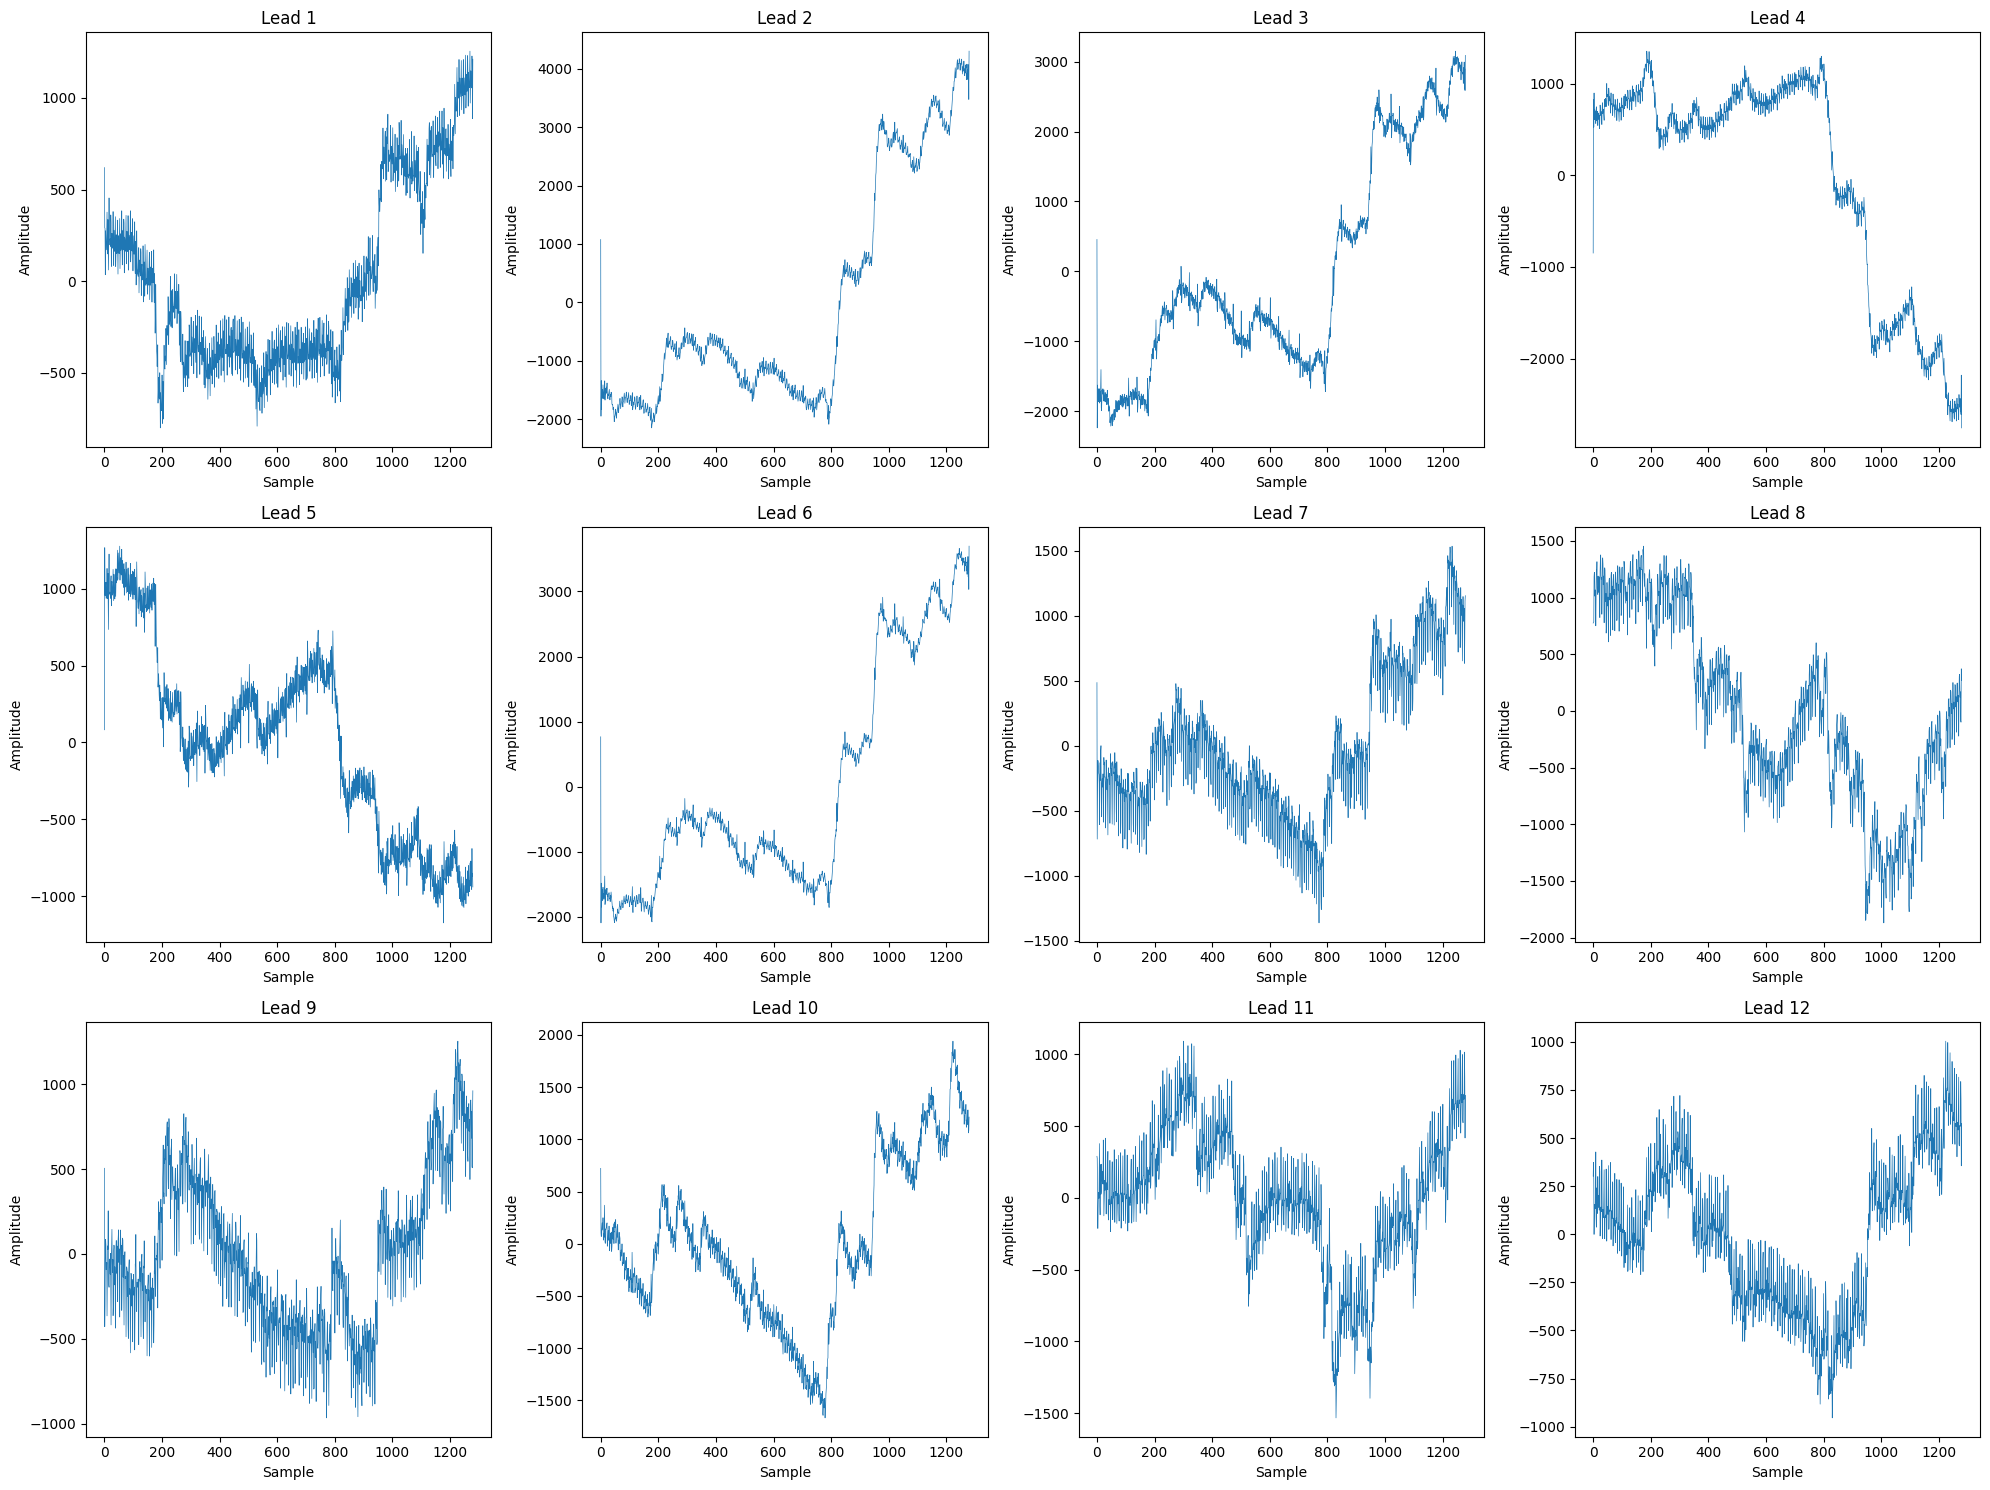

In [68]:
expA_dataset.plot_record(0)

## Stage 2: Class Exclusion

First, we need to exclude some ECG classes from the `expA_dataset` and use these excluded classes (and corresponding records) as the test set.

### Step 1: Create a list of all classes

In [23]:
classes = [record[0] for record in expA_dataset]
len(classes)

22353

In [35]:
classes[0:10]

[['myocardial infarction'],
 ['atrial fibrillation'],
 ['sinus rhythm'],
 ['ventricular fibrillation',
  'coronary heart disease',
  'myocardial infarction'],
 ['atrial fibrillation'],
 ['bundle branch block'],
 ['myocardial infarction'],
 ['myocardial infarction'],
 ['myocardial infarction'],
 ['sinus rhythm']]

In [25]:
# index of expA_dataset[i][0] should correspond to classes[i]
print(expA_dataset[22222][0])
print(classes[22222])

['left axis deviation', 'sinus rhythm', 'left anterior fascicular block']
['left axis deviation', 'sinus rhythm', 'left anterior fascicular block']


### Step 2: Count the occurrences of each class

In [29]:
# Flatten the list of classes
flat_classes = [cls for record in classes for cls in record]

In [30]:
class_counts = pd.Series(flat_classes).value_counts()

In [32]:
class_counts.head(15)

sinus rhythm                                        18172
myocardial infarction                                5629
left axis deviation                                  5146
abnormal QRS                                         3389
left ventricular hypertrophy                         2359
t wave abnormal                                      2345
myocardial ischemia                                  2175
left anterior fascicular block                       1626
atrial fibrillation                                  1529
ventricular ectopics                                 1154
incomplete right bundle branch block                 1118
st depression                                        1009
sinus tachycardia                                     827
1st degree av block                                   797
nonspecific intraventricular conduction disorder      789
dtype: int64

In [38]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 952.5 kB/s eta 0:00:00


In [39]:
# Create a DataFrame for each variable
classes_df = pd.DataFrame(classes)
flat_classes_df = pd.DataFrame(flat_classes, columns=['Flat Classes'])
class_counts_df = class_counts.reset_index().rename(columns={'index': 'Class', 0: 'Count'})

# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('ptb_class_info.xlsx', engine='xlsxwriter')

# Write each DataFrame to a different worksheet
classes_df.to_excel(writer, sheet_name='Classes', index=False)
flat_classes_df.to_excel(writer, sheet_name='Flat Classes', index=False)
class_counts_df.to_excel(writer, sheet_name='Class Counts', index=False)

# Close the Pandas Excel writer and output the Excel file
writer.save()

<ipython-input-39-90de8020521a>:15: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


### Step 3: Define the classes to exclude

In [42]:
classes_to_exclude = [
    'myocardial infarction',
    'left bundle branch block',
    't wave abnormal',
    'sinus bradycardia',
    'inferior ischaemia'
]

In [54]:
# Create functions to exclude/include records containing certain classes
def exclude_classes(record, classes_to_exclude):
    return not any([cls in record[0] for cls in classes_to_exclude])

def include_classes(record, classes_to_exclude):
    return any([cls in record[0] for cls in classes_to_exclude])

In [50]:
# Apply the function to the dataset
filtered_dataset = [record for record in expA_dataset if exclude_classes(record, classes_to_exclude)]

In [53]:
filtered_dataset[5000][0]

['atrial fibrillation',
 'left axis deviation',
 'left anterior fascicular block']

The ```train_set``` can be split into ```current_train``` (85%) and ```current_val``` (15%).

In [56]:
# Set the seed for the random number generator
torch.manual_seed(0)

# Get the length of the train_set
length = len(filtered_dataset)

# Calculate the lengths of the splits
train_length = int(0.85 * length)
val_length = length - train_length

# Split the dataset
current_train, current_val = random_split(filtered_dataset, [train_length, val_length])

In [57]:
len(current_train), len(current_val)

(11534, 2036)

In [70]:
assert len(current_train) + len(current_val) == len(filtered_dataset)

In [58]:
# Diagnoses
current_train[0][0]

['sinus rhythm']

In [ ]:
# 12-lead ECG (np array)
current_train[0][1]

In [69]:
test_dataset = [record for record in expA_dataset if include_classes(record, classes_to_exclude)]

In [72]:
len(test_dataset)

8783

In [73]:
assert len(test_dataset) == len(expA_dataset) - len(filtered_dataset)

In [74]:
assert len(test_dataset) + len(current_train) + len(current_val) == len(expA_dataset)

## Stage 3: ECG Classification Model Pipeline

Now that our data is preprocessed, we can begin working on the Model Pipeline itself. The ECG Classification Model Pipeline will consist of three components:

1. `TextEncoder()` class

2. `ECGEncoder()` class

4. `CLIPModel()` class

An overview and outline of each of these components can be found below in their respective subsections.

In [75]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### TextEncoder()

Create a class, ```TextEncoder()``` that is used to convert the description of the (dx_modality) diagnosis class into an embeddings using the pretrained, base ClinicalBERT model.

- Input should be a concatenated using comma or blank space string of diagnoses/dx_modality per ECG signal.
- Use processed CSV files (dx_modality only)
- Frozen weights (since it's already pretrained)

In [76]:
class TextEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(self.device)

        # Add embed_dim attribute
        self.embed_dim = self.model.config.hidden_size


    def encode(self, text_list):
        # Check if text_list is a string representation of a list
        if isinstance(text_list, str):
            text_list = ast.literal_eval(text_list)
        # Convert list of strings to a single string
        text = ', '.join(text_list)
        # Tokenize text
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # Move inputs to the correct device
        inputs = {name: tensor.to(self.device) for name, tensor in inputs.items()}
        # Get embeddings from ClinicalBERT model
        with torch.no_grad():
            embeddings = self.model(**inputs).last_hidden_state
        # Average the embeddings to get single vector per each input
        embeddings = torch.mean(embeddings, dim=1)
        return embeddings.to(self.device)

In [77]:
text_encoder = TextEncoder(device).to(device)
# Example
embeddings = text_encoder.encode(current_train[0][0])

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [78]:
print(embeddings.size())
print(type(embeddings))

torch.Size([1, 768])
<class 'torch.Tensor'>


### ECGEncoder()

- Input is ECG signal, output will be embeddings of ECG signal
- This is going to be model in model.py
- Model weights are updated iteratively
- optimizer = torch.optim.Adam(clip_model.ECGEncoder.parameters())

In [79]:
class ECGEncoder(nn.Module):
    def __init__(self):
        super(ECGEncoder, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 4
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 5
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 6
        self.conv6 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm1d(512)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 7
        self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm1d(512)
        self.relu7 = nn.ReLU()
        self.pool7 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 8
        self.conv8 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm1d(512)
        self.relu8 = nn.ReLU()
        self.pool8 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 9
        self.conv9 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm1d(512)
        self.relu9 = nn.ReLU()
        self.pool9 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 10
        self.conv10 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn10 = nn.BatchNorm1d(512)
        self.relu10 = nn.ReLU()
        self.pool10 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Fully Connected Layer 1
        # self.fc1 = nn.Linear(512*4, 768)
        self.relu11 = nn.ReLU()

        # Add embed_dim attribute
        self.embed_dim = 768

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Layer 6
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool6(x)

        # Layer 7
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.pool7(x)

        # Layer 8
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.pool8(x)

        # Layer 9
        x = self.conv9(x)
        x = self.bn9(x)
        x = self.relu9(x)
        x = self.pool9(x)

        # Layer 10
        x = self.conv10(x)
        x = self.bn10(x)
        x = self.relu10(x)
        x = self.pool10(x)

        # Flatten the output of the convolutional layers
        print(x.size())
        x = x.view(x.size(0), -1)

        # Initialize self.fc1 here, using the size of x
        if not hasattr(self, 'fc1'):
            self.fc1 = nn.Linear(x.size(1), self.embed_dim).to(x.device)
        x = self.fc1(x)
        x = self.relu11(x)

        return x

In [80]:
# Instantiate the model
model = ECGEncoder()

# Convert the numpy array to a PyTorch tensor
input_data = torch.from_numpy(current_train[0][1]).float()

# Add an extra dimension to the tensor to represent the batch size
input_data = input_data.unsqueeze(0)

# Pass the tensor through the model
output = model(input_data)

# Print the output
print(output)

torch.Size([1, 512, 1])
tensor([[5.5098e-04, 2.9857e-01, 2.3207e-01, 1.3990e-01, 7.8928e-02, 0.0000e+00,
         0.0000e+00, 2.1255e-01, 0.0000e+00, 9.4320e-01, 0.0000e+00, 0.0000e+00,
         2.0959e-01, 0.0000e+00, 1.6988e-01, 0.0000e+00, 3.3279e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1436e-01, 0.0000e+00,
         4.3770e-01, 1.0224e-01, 3.6113e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1528e-01, 0.0000e+00, 3.1246e-01,
         0.0000e+00, 6.3379e-02, 1.4286e-01, 1.0842e-01, 2.4619e-01, 4.1758e-01,
         1.1875e-01, 1.3027e-01, 2.3256e-01, 5.2706e-01, 1.0412e-01, 0.0000e+00,
         0.0000e+00, 9.2943e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5666e-02,
         0.0000e+00, 0.0000e+00, 8.3465e-02, 7.0144e-01, 0.0000e+00, 0.0000e+00,
         1.8254e-01, 2.8095e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
    

In [81]:
# Set the model to evaluation mode
model.eval()

# Pass the data through the model
output = model(input_data)

print(type(output))

torch.Size([1, 512, 1])
<class 'torch.Tensor'>


In [82]:
# Count the parameters
num_params = count_parameters(model)
print(f'The ECGEncoder model has {num_params} trainable parameters.')

The ECGEncoder model has 4073232 trainable parameters.


### CLIPModel

The final component of the Model Pipeline is to create a `ClIPModel` class which takes `TextEncoder` and `ECGEncoder` to train the final model with contrastive loss.

```
# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minibatch of aligned images
# T[n, l] - minibatch of aligned texts
# W_i[d_i, d_e] - learned proj of image to embed
# W_t[d_t, d_e] - learned proj of text to embed
# t - learned temperature parameter
# extract feature representations of each modality
I_f = image_encoder(I) #[n, d_i]
T_f = text_encoder(T) #[n, d_t]
# joint multimodal embedding [n, d_e]
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
# scaled pairwise cosine similarities [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t)
# symmetric loss function
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
Figure 3. Numpy-like pseudocode for the core of an implementation of CLIP
```

In [83]:
# V1
class CLIPModel(nn.Module):
    def __init__(self, text_encoder, ecg_encoder, embed_dim, temperature):
        super(CLIPModel, self).__init__()
        self.text_encoder = text_encoder
        self.ecg_encoder = ecg_encoder
        self.temperature = temperature
        self.W_i = nn.Linear(ecg_encoder.embed_dim, embed_dim)
        self.W_t = nn.Linear(text_encoder.embed_dim, embed_dim)

    def forward(self, ecgs, texts):
        # Extract feature representations of each modality
        I_f = self.ecg_encoder(ecgs)  # [n, d_i]
        T_f = torch.stack([self.text_encoder.encode(text).squeeze() for text in texts])  # [n, d_t]

        # Joint multimodal embedding [n, d_e]
        I_e = F.normalize(self.W_i(I_f), dim=1)
        T_e = F.normalize(self.W_t(T_f), dim=1)

        # print(f"I_e shape: {I_e.shape}")
        # print(f"T_e shape: {T_e.shape}")

        # Scaled pairwise cosine similarities [n, n]
        logits = torch.matmul(I_e, T_e.t()) / self.temperature

        # Symmetric loss function
        labels = torch.arange(len(ecgs)).to(ecgs.device)
        loss_i = F.cross_entropy(logits, labels)
        loss_t = F.cross_entropy(logits.t(), labels)
        loss = (loss_i + loss_t) / 2

        return loss

### DataLoaders

In [ ]:
# Instantiate the encoders
text_encoder = TextEncoder(device).to(torch.device("cuda"))
ecg_encoder = ECGEncoder().to(torch.device("cuda"))

# Instantiate the encoders and the model
CLIP_model = CLIPModel(text_encoder, ecg_encoder, embed_dim=512, temperature=0.1)

In [ ]:
# Parameters
lr = 1e-4
weight_decay = 5e-3
optimizer = torch.optim.Adam(CLIP_model.ecg_encoder.parameters(), lr=lr, weight_decay=weight_decay)
num_epochs = 5

## Model training - current_train dataset

In [85]:
len(current_train)

11534

In [ ]:
current_train_loader = DataLoader(current_train, batch_size=32, collate_fn=collate_fn)

In [ ]:
# V1
def train_model(model, optimizer, num_epochs, device, train_loader):
    model.to(device)
    train_losses = []
    train_labels = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(enumerate(train_loader, 0), total=len(train_loader), leave=False)

        for i, data in pbar:
            labels = data[0]
            ecgs = data[1].float().to(device)

            optimizer.zero_grad()
            loss = model(ecgs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_description(f"Batch {i+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}, Running Loss: {running_loss/(i+1):.4f}")

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}')

    # Save the model
    torch.save(model.ecg_encoder.state_dict(), 'ecg_encoder.pth')

    return model, train_losses

In [ ]:
model, train_losses = train_model(model=CLIP_model,
                                  optimizer=optimizer,
                                  num_epochs=num_epochs,
                                  device=device,
                                  train_loader=current_train_loader)

## Model validation - current_val dataset